### Authors’ Note:

This is the 2nd of 3 notebooks prepared on [2020 Winter School on Synchronization](https://complex-systems-turkey.github.io/). 

If you have any questions or comments please contact us at [GitHub repository](https://github.com/complex-systems-turkey/winter-2020-synchronization).

* [Oğuz Kaan Yüksel](https://github.com/okyksl)
* [Enis Simsar](https://github.com/enisimsar)
* [Galip Ümit Yolcu](https://github.com/gumityolcu)
* [Suzan Üsküdarlı](https://github.com/uskudarli)

# Chaos Theory

In higher dimensions we represent the state with the vector $\mathbf{x} \in \mathbb{R}^n$. Since we know $\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x})$, a numerical solution can be computed starting from an initial condition $t_0$ using three numerical methods we discussed yesteday. <br><br>
As an example, consider the Lorenz system ($\mathit{n=3}$) given by the set of differential equations:<br>
$\dot{x} = \sigma (y-x)$<br>
$\dot{y} = x(\rho-z)-y$<br>
$\dot{z} = xy - \beta z$<br>

Lorenz system produces chaotic dynamics under certain parameters sets. One such set is $(\sigma,\rho,\beta) = (10, 28, 2.667 )$, which produces the celebrated ['Lorenz Butterfly'](https://www.google.com/search?client=safari&sxsrf=ALeKk03RKc84pQCltiGRXrIV45xJpK2ZSA%3A1583567768569&source=hp&ei=mFNjXsWoHs-6aZT9ocgL&q=lorenz+butterfly&oq=lorenz+b&gs_l=psy-ab.1.0.35i39i19j0l6j0i203l3.827.1484..3980...1.0..0.150.985.0j8......0....1..gws-wiz.......35i39j0i67j0i131.TEZnEqEFNsU) in the state space (The space of $(x,y,z)$). 
In this part, we will try to replicate Lorenz Butterfly using three different integrators.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl

In [2]:
#Plot configurations
mpl.rcParams['figure.dpi'] = 100
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["axes.grid"] = True 

### Integrators

In [3]:
def integrate(estimator, f, x, t=0, dt=0.01, n=100):
    """Numerical approximation of a trajectory in a vector field

    Parameters
    ----------
    estimator : function
        A function that estimates the change of value in trajectory from a given point.
    f         : function
        A function that returns a vector field (or a gradient) on a given point.
    x         : array_like
        Initial value point of the trajectory.
    t         : float | tuple | array_like
        Initial time point | start and end time values | whole time points of the integration.
    dt        : float
        Time step will be used in the integration.
        Will only be used if `t` is not given as array_like.
    n         : int
        Number of steps will be used in the integration.
        Will only be used together with `dt` when `t` denotes the initial time value.

    Returns
    -------
    xs        : array_like
        a list of value points calculated with integration that start from given `x`.
    ts        : array
        a list of time points that corresponds to given value points.
    """

    # calculate time points that will be used in the integration
    if isinstance(t, float): # if given as (start) time point
        ts = np.arange(t, t + dt * n, dt) # start integrating from t using `dt` and `n`
    elif isinstance(t, tuple): # if given (start, end) time points
        ts = np.arange(t[0], t[1]+dt, dt) # utilize dt to find intermediate points 
    else: # if given as an array of time points
        ts = t

    xs = [ x ]
    for i in range(1, len(ts)):
        dt = ts[i] - ts[i-1] # calculate time diff
        x = x + estimator(f, x, ts[i], dt) # calculate next point
        xs.append(x)
    return np.stack(xs), ts

def euler(f, x, t=0, dt=0.01):
    """Estimates a change in trajectory using Euler's Method.

    Parameters
    ----------
    f         : function
        A function that returns a vector field (or a gradient) on a given point.
    x         : array_like
        Value point of the estimation.
    t         : float | tuple | array
        Time point of the estimation. 
    dt        : float
        Time step will be used in estimation.

    Returns
    -------
    dx        : array_like
        Change estimated by Euler's Method.
    """
    
    return f(x, t) * dt

def heun(f, x, t=0, dt=0.01):
    """Estimates a change in trajectory using Heun's Method.

    Parameters
    ----------
    f         : function
        A function that returns a vector field (or a gradient) on a given point.
    x         : array_like
        Value point of the estimation.
    t         : float | tuple | array
        Time point of the estimation. 
    dt        : float
        Time step will be used in estimation.

    Returns
    -------
    dx        : array_like
        Change estimated by Heun's Method.
    """
    
    d_euler = euler(f, x, t, dt) # calculate change with Euler's
    x_euler = x + d_euler # calculate point estimated with Euler's
    return (d_euler + f(x_euler, t + dt) * dt) * 0.5 # apply Heun's correction

def rk4(f, x, t, dt):
    """Estimates a change in trajectory using Runge-Kutta 4th order Method.

    Parameters
    ----------
    f         : function
        A function that returns a vector field (or a gradient) on a given point.
    x         : array_like
        Value point of the estimation.
    t         : float | tuple | array
        Time point of the estimation. 
    dt        : float
        Time step will be used in estimation.

    Returns
    -------
    dx        : array_like
        Change estimated by RK4 Method.
    """
    
    k1 = f(x, t) * dt
    k2 = f(x + k1 * 0.5, t + dt * 0.5) * dt
    k3 = f(x + k2 * 0.5, t + dt * 0.5) * dt
    k4 = f(x + k3, t + dt * 0.5) * dt
    return (k1 + 2.0 * k2 + 2.0 * k3 + k4) / 6.0

### Lorenz Systems

Let us define Lorenz equations as a Python function (please note that in the function defined below as 'Lorenz', y is the state vector and t is the time vector. Not to be confused with arguments of the Lorenz equations which are time independent!):

In [4]:
def lorenz(sigma=10, rho=28, beta=2.667):
    """Defines a Lorenz dynamical system with given parameters.
    
    Returns
    -------
    _lorenz   : function
        Derivative function of the Lorenz system.
    """
    def _lorenz(x, t):
        return np.asarray([
            sigma * (x[1] - x[0]),
            x[0] * (rho - x[2]) - x[1],
            -beta * x[2] + x[0] * x[1]
        ])
    return _lorenz

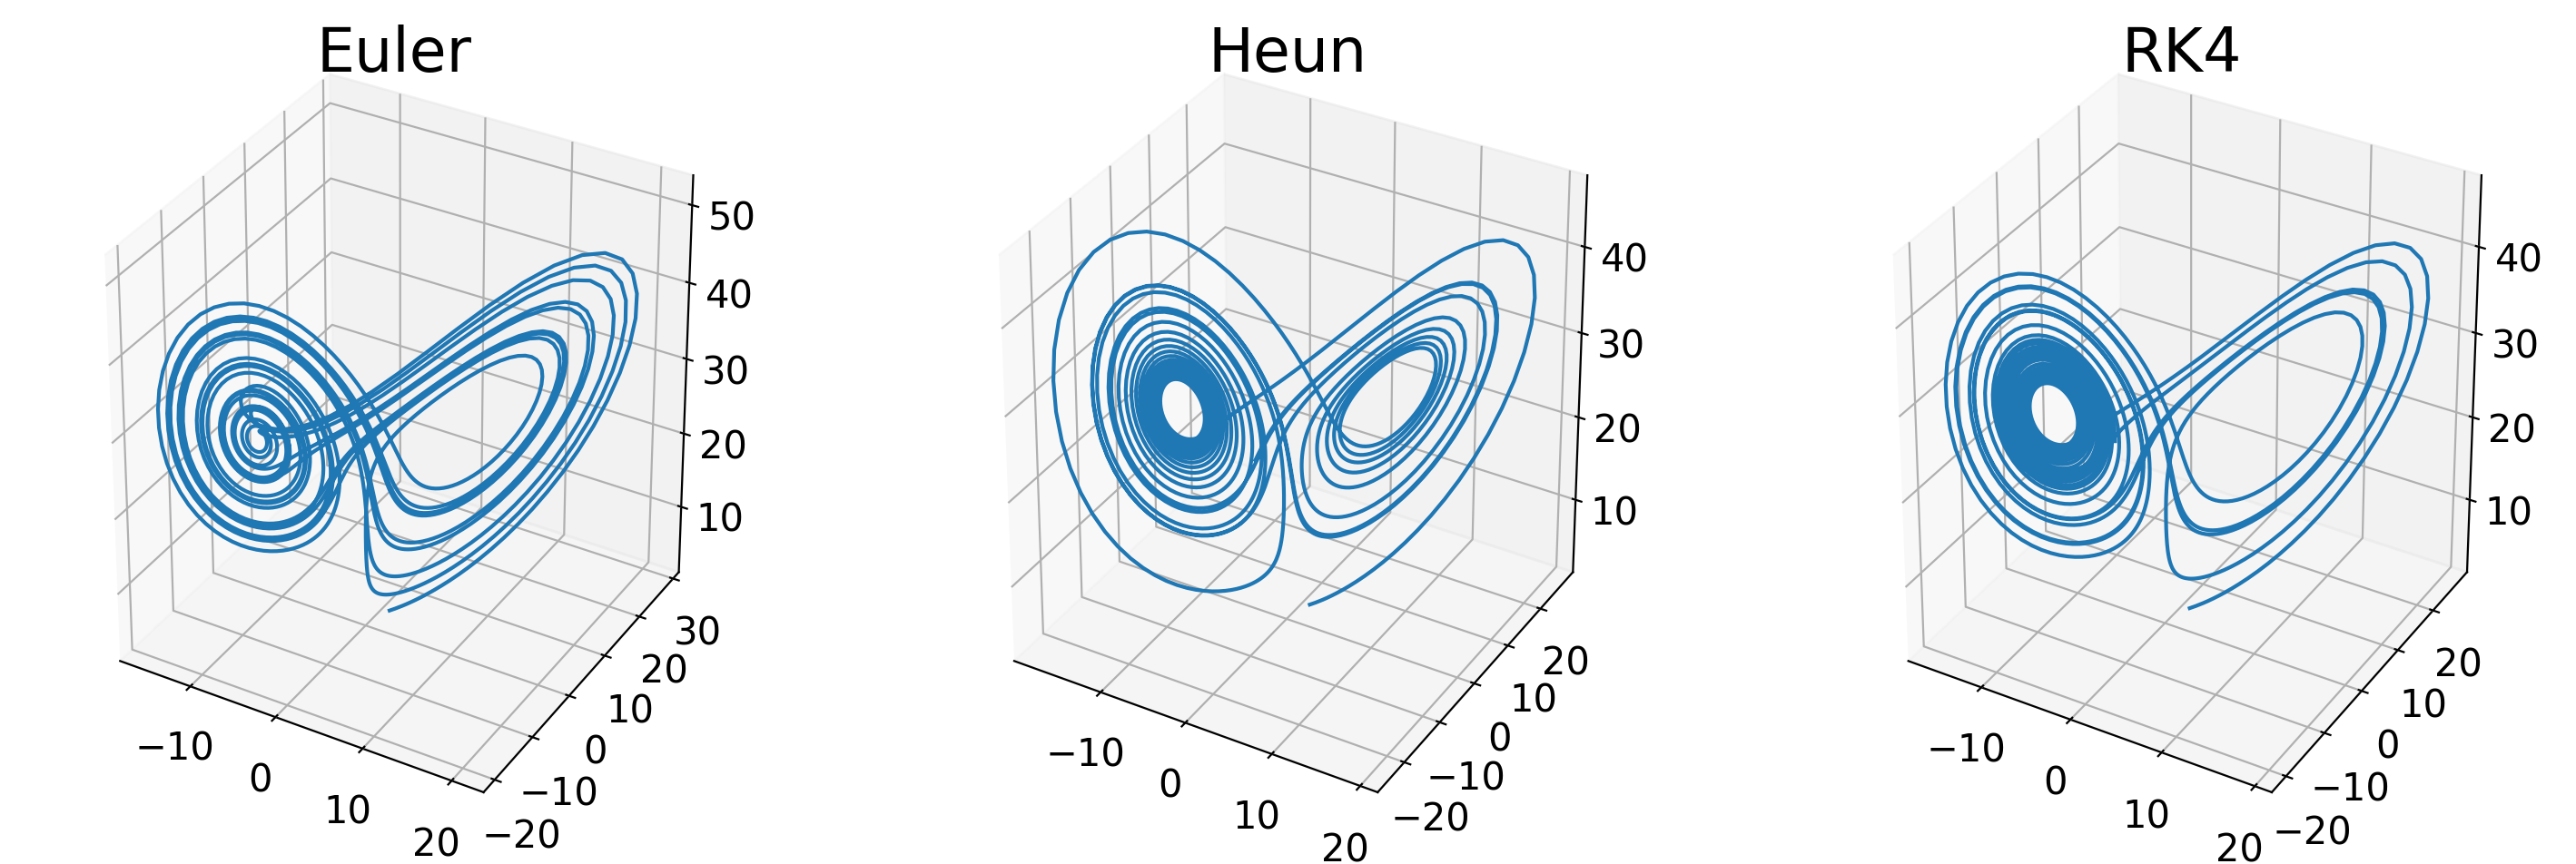

In [5]:
# Use all three algorithm to integrate and then compare your results by plotting their phase spaces
# Remember that Lorenz equations have no analytical solution 

# construct lorenz system with hyperparameters
params = {
    'sigma': 10,
    'rho': 28,
    'beta': 2.667  
}
system = lorenz(**params)

# define initial conditions and parameters of the integration
x0 = np.asarray([ 1.5, 3.0, 2.0 ])
t = (0, 20)
dt = 0.01

# calculate trajectory of the initial point with numerical integration
x_euler, ts = integrate(euler, f=system, x=x0, t=t, dt=dt)
x_heun, _ = integrate(heun, f=system, x=x0, t=ts, dt=dt)
x_rk4, _ = integrate(rk4, f=system, x=x0, t=ts, dt=dt)

# plot trajectories seperately in 3D
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot(xs=x_euler[:,0], ys=x_euler[:,1], zs=x_euler[:,2])
ax1.set_title('Euler', fontsize=24)

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot(xs=x_heun[:,0], ys=x_heun[:,1], zs=x_heun[:,2])
ax2.set_title('Heun', fontsize=24)

ax3 = fig.add_subplot(133, projection='3d')
ax3.plot(xs=x_rk4[:,0], ys=x_rk4[:,1], zs=x_rk4[:,2])
ax3.set_title('RK4', fontsize=24);

## Lyapunov Exponent of Lorenz System

### Exponential Divergence of Nearby Trajectories

The motion on the attractor exhibits sensitive dependence on initial conditions: infinitesimally close trajectories diverge exponentially fast from each other. We define the distance between trajectories as:

\begin{align}
\|\delta (t)\| \approx \|\delta_0\| e^{\Lambda t}
\end{align}

where $\delta$ is the a measure of tiny seperation between trajectories, $\Lambda$ is constant defining the speed of divergence. For these two trajectories to diverge from each other exponentially $\Lambda$ should be greater than 0, and the system is then deduced to be chaotic. 

Below, we will study the difference in trajectories of two identical Lorenz systems with a slight difference in x initial condition only: (-8, 7, 27) and (-8.01, 7, 27)

In [6]:
# define the initial conditions of one Lorenz slightly different from the other Lorenz
x0 = np.array([-8.0, 7.0, 27.0])
x1 = np.array([-8.01, 7.0, 27.0])
t = (0, 20)
dt = 0.01

# calculate trajectory of the initial points with numerical integration
xs0, ts = integrate(rk4, f=system, x=x0, t=t, dt=dt)
xs1, _ = integrate(rk4, f=system, x=x1, t=ts, dt=dt)

Let us define the distance between trajectories, $\delta$

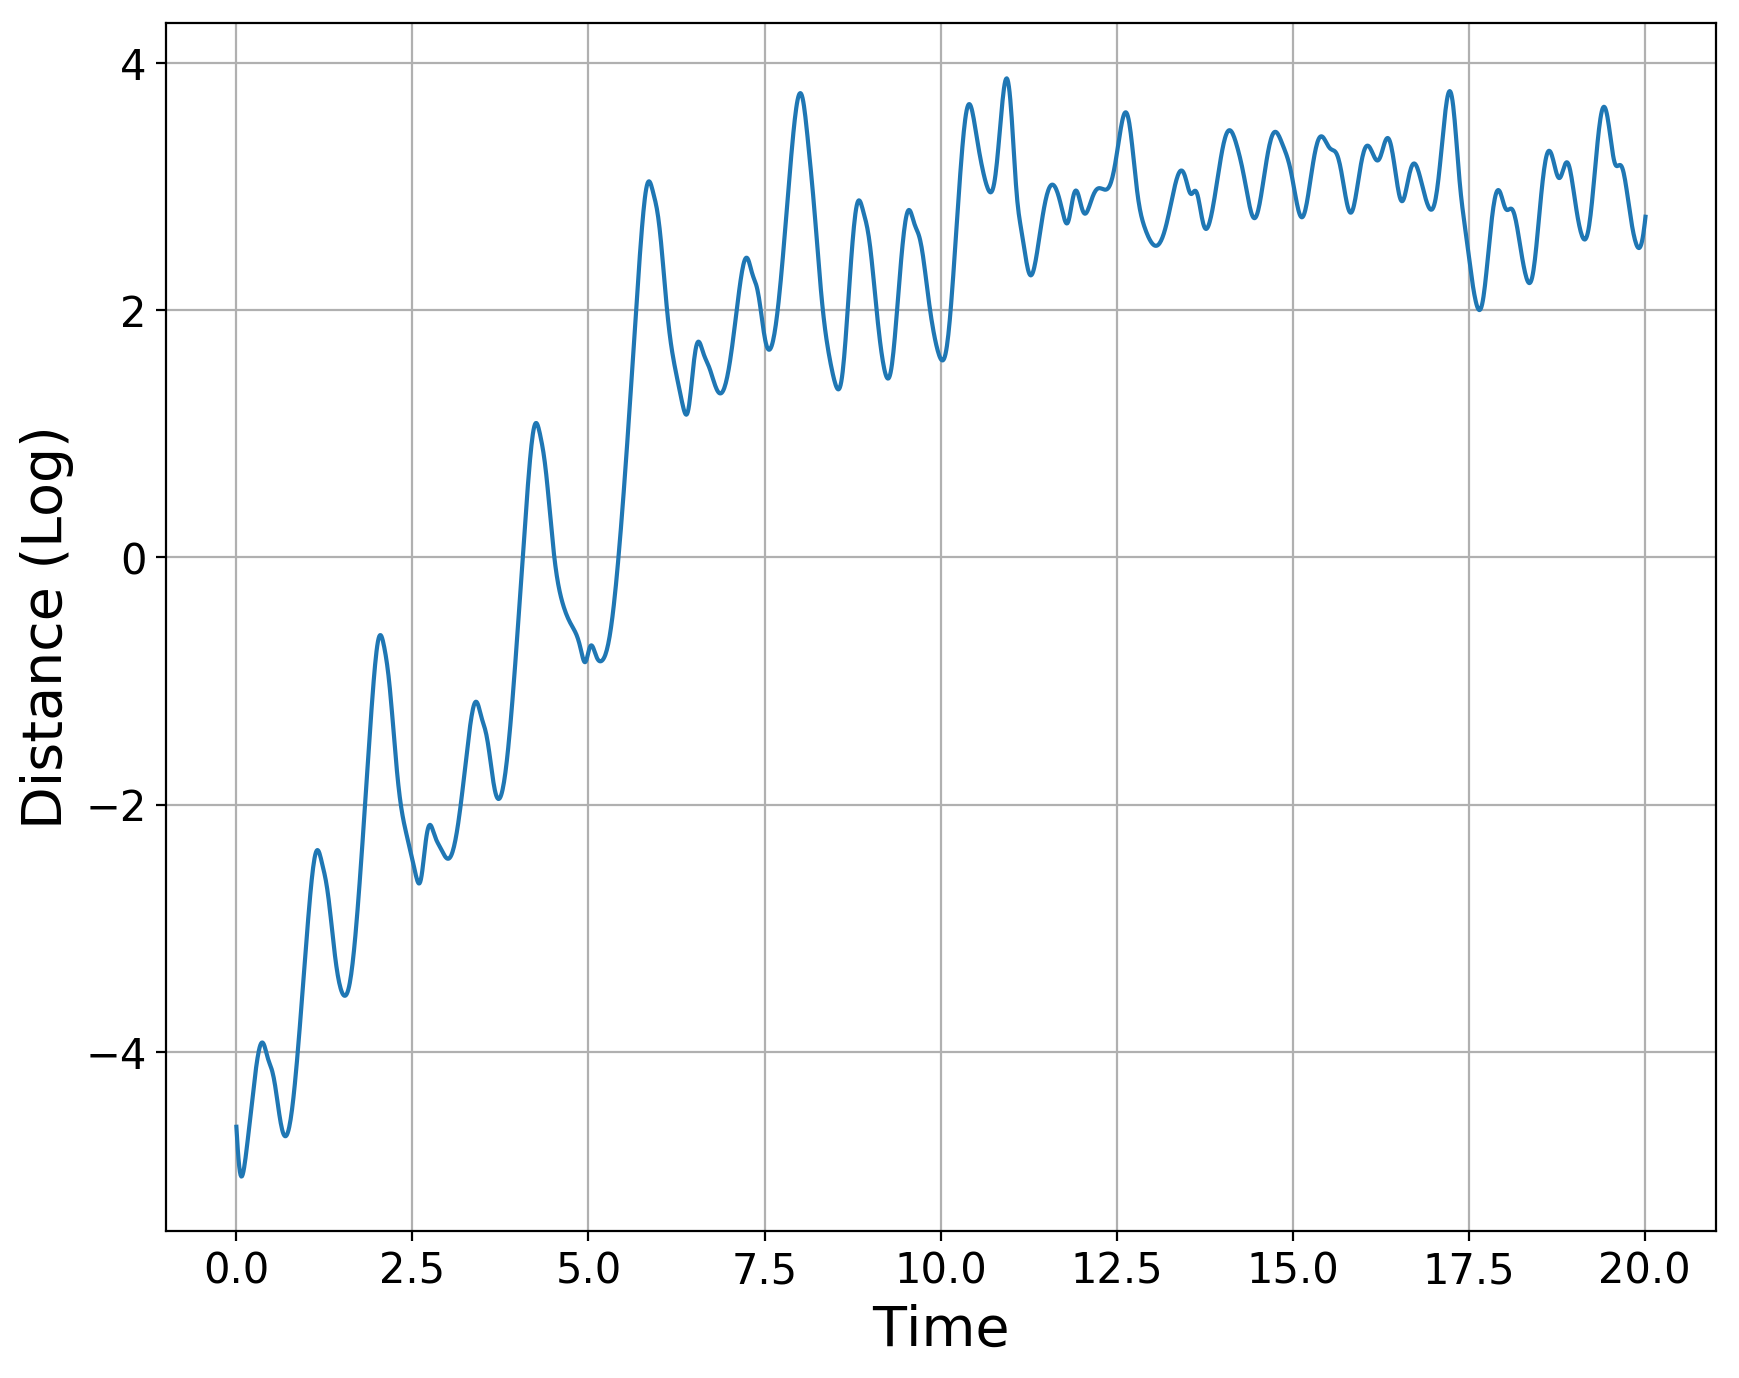

In [7]:
# calculate L_2 distance between trajectories
distance = np.linalg.norm(xs0 - xs1, axis=1, ord=2) # axis denotes where the norm will be calculated

# take logarithm of distances
distance = np.log(distance)

# plot distance over time
plt.plot(ts, distance)
plt.xlabel('Time')
plt.ylabel('Distance (Log)');

Now we will fit a line to the increasing part of ln $\delta$. We rule out the saturated part as the trajectories move in a bounded space, so that the separation on the attractor is limited to a value. 

Lyapunov exponent:  0.9279421031747723


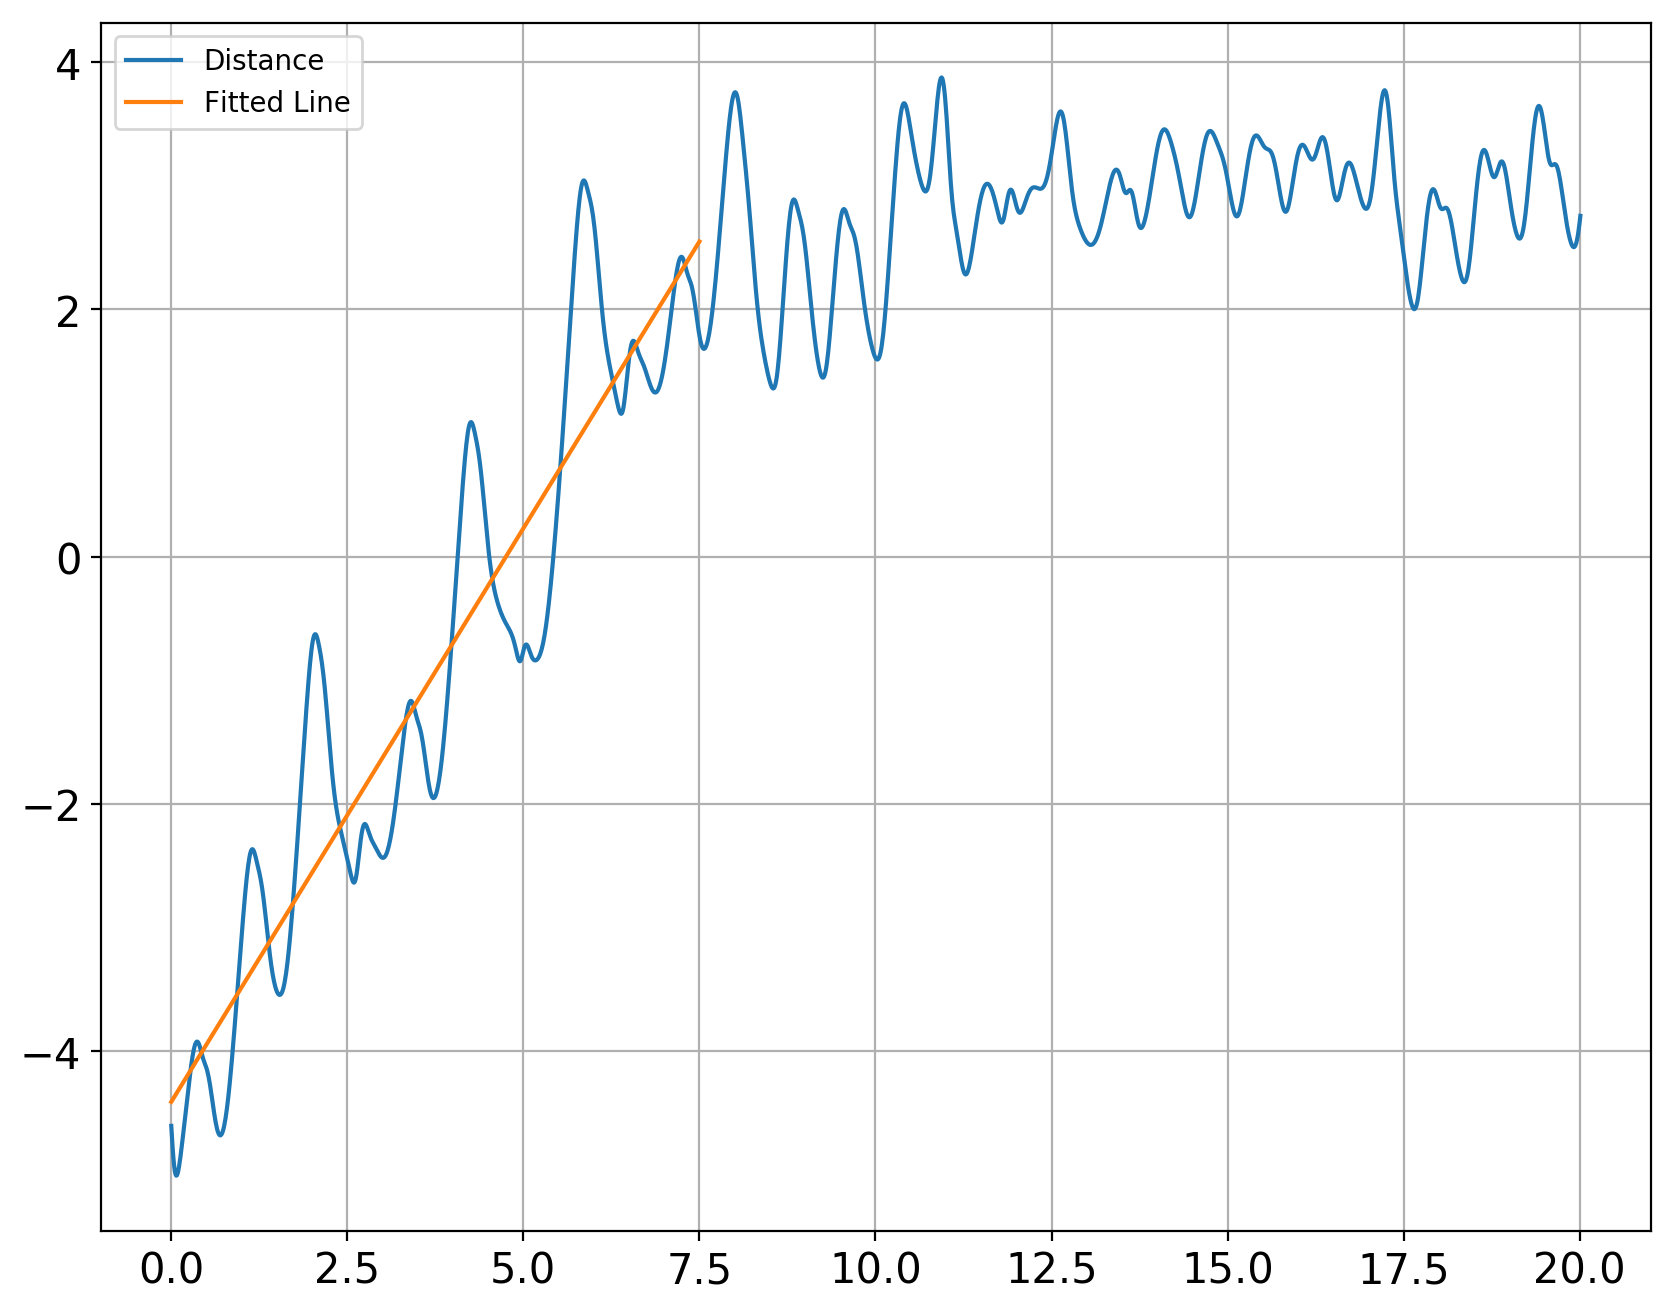

In [8]:
# determine cutoff value manually
cutoff = 7.5

# calculate the smallest index that is larger than cutoff
index = np.argmax(ts > cutoff)

# use polyfit function to fit a line to calculate the Lyapunov exponent
m, y0 = np.polyfit(ts[:index], distance[:index], deg=1) # take only the relevant segment with [:index] slicing

# plot the distance over time together with line fitted
plt.plot(ts, distance)
plt.plot([0, cutoff], [y0, cutoff * m + y0]) # plot line by giving start and end point calculated from slope
plt.legend(['Distance', 'Fitted Line']);
print('Lyapunov exponent: ', m)

# Synchronization of Chaos

In this example, we use two identical Lorenz systems coupled as below:<br>

\begin{align}
\mathbf{\dot{x}_1}=\mathbf{f}(\mathbf{x_1})+\alpha H(\mathbf{x_2}-\mathbf{x_1})\\
\mathbf{\dot{x}_2}=\mathbf{f}(\mathbf{x_2})+\alpha H(\mathbf{x_1}-\mathbf{x_2})\\
\end{align}<br>
where $\mathbf{{x}_1}$ and $\mathbf{{x}_2}$ in $\mathbb{R}^n $ are the state vectors of the two Lorenz systems.
We assume that the two systems are globally coupled, so $H = I$, the identity matrix, and $\alpha$ is the strength of the coupling.<br> 


In [9]:
def couple_identical(f, h, n, alpha=0.1):
    """Defines a coupled system consisting of identical subsytems.

    Parameters
    ----------
    f         : function
        A vector field defining the isolated dynamics of subsystems.
    h         : function | array_like
        Coupling function or matrix defining the coupling dynamics between two subsystems.
    n         : int
        Number of identical subsystems to be considered.
    alpha     : float
        Coupling strength.

    Returns
    -------
    F         : function
        A vector field defining the dynamics of the whole system.
    """
    
    def F(x, t):
        k = x.shape[1] # number of parameters in each subsystem, x's shape is (n x k)
        
        # calculate differences matrix
        x_row = np.repeat(x[:, np.newaxis, ...], n, axis=1) # (n x n x k)
        x_col = np.repeat(x[np.newaxis, ...], n, axis=0) # (n x n x k)
        x_diff = (x_col - x_row) # (n x n x k)
        
        # calculate coupling by applying h to each *difference state* of (k x 1)
        if callable(h): # if h is given as function (nonlinear)
            dx_coup = np.zeros((n, n, k))
            for i in range(n):
                for j in range(n):
                    dx_coup[i, j, :] = h(x_diff[i, j, :])
        else: # if h is given explicitly as matrix (linear)
            dx_coup = alpha * np.tensordot(h, x_diff, axes=1) # (n x n x k)
        # calculate internal dynamics
        dx_diag = np.zeros((n, n, k)) # (n x n x k)
        for i in range(n):
            dx_diag[i, i, :] = f(x[i, :], t) # put internal dynamics to diagonal of tensor matrix
        
        # sum over columns to get derivatives for each subsystem
        return np.sum(dx_diag + dx_coup, axis=1) # (n x 1 x k ~ n x k)
    return F

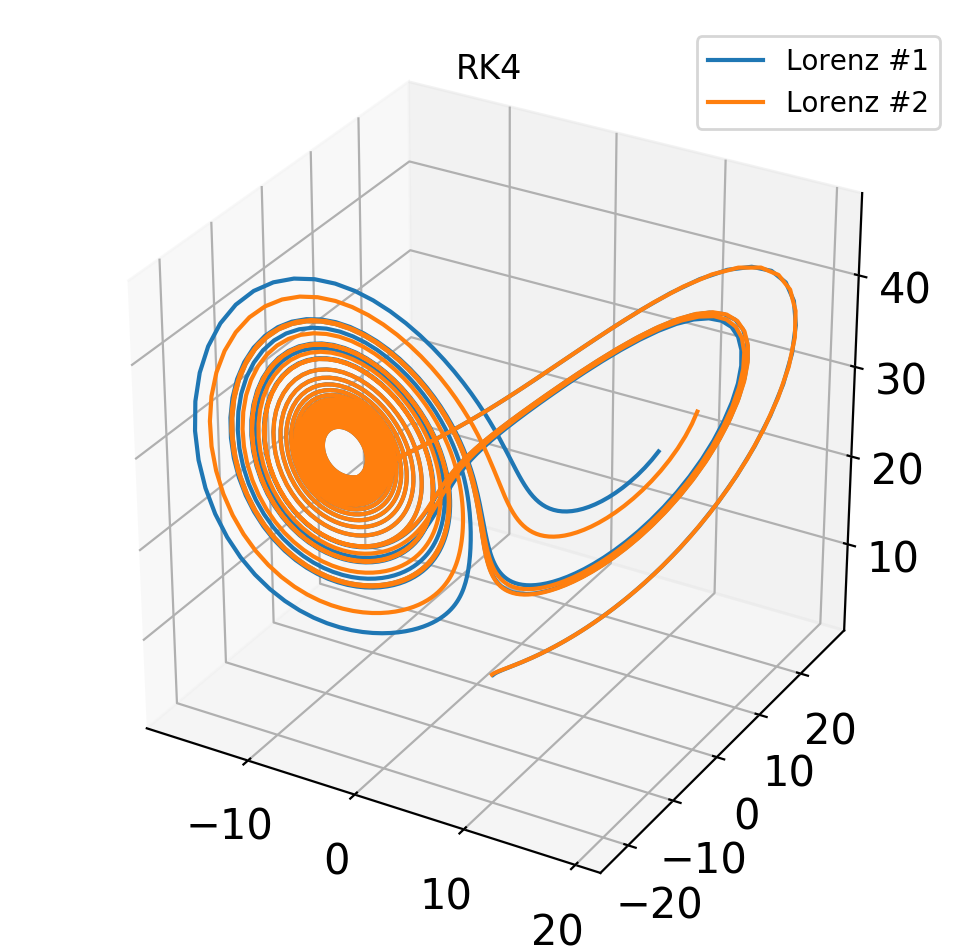

In [10]:
# define coupled lorenz system
params = {
    'sigma': 10,
    'rho': 28,
    'beta': 2.667  
}
alpha = 0.1
system = couple_identical(lorenz(**params), h=np.eye(2), n=2, alpha=alpha)

# define the initial conditions of one Lorenz slightly different from the other Lorenz
x0 = np.array([ [1.1, 1.0, 1.0], [1.0, 1.0, 1.0] ])
t = (0, 20)
dt = 0.01

# calculate trajectory of the initial point with numerical integration
x_rk4, ts = integrate(rk4, f=system, x=x0, t=t, dt=dt)

# plot trajectories together in 3D
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs=x_rk4[:, 0, 0], ys=x_rk4[:, 0, 1], zs=x_rk4[:, 0, 2])
ax.plot(xs=x_rk4[:, 1, 0], ys=x_rk4[:, 1, 1], zs=x_rk4[:, 1, 2])
ax.set_title('RK4')
ax.legend(['Lorenz #1', 'Lorenz #2']);

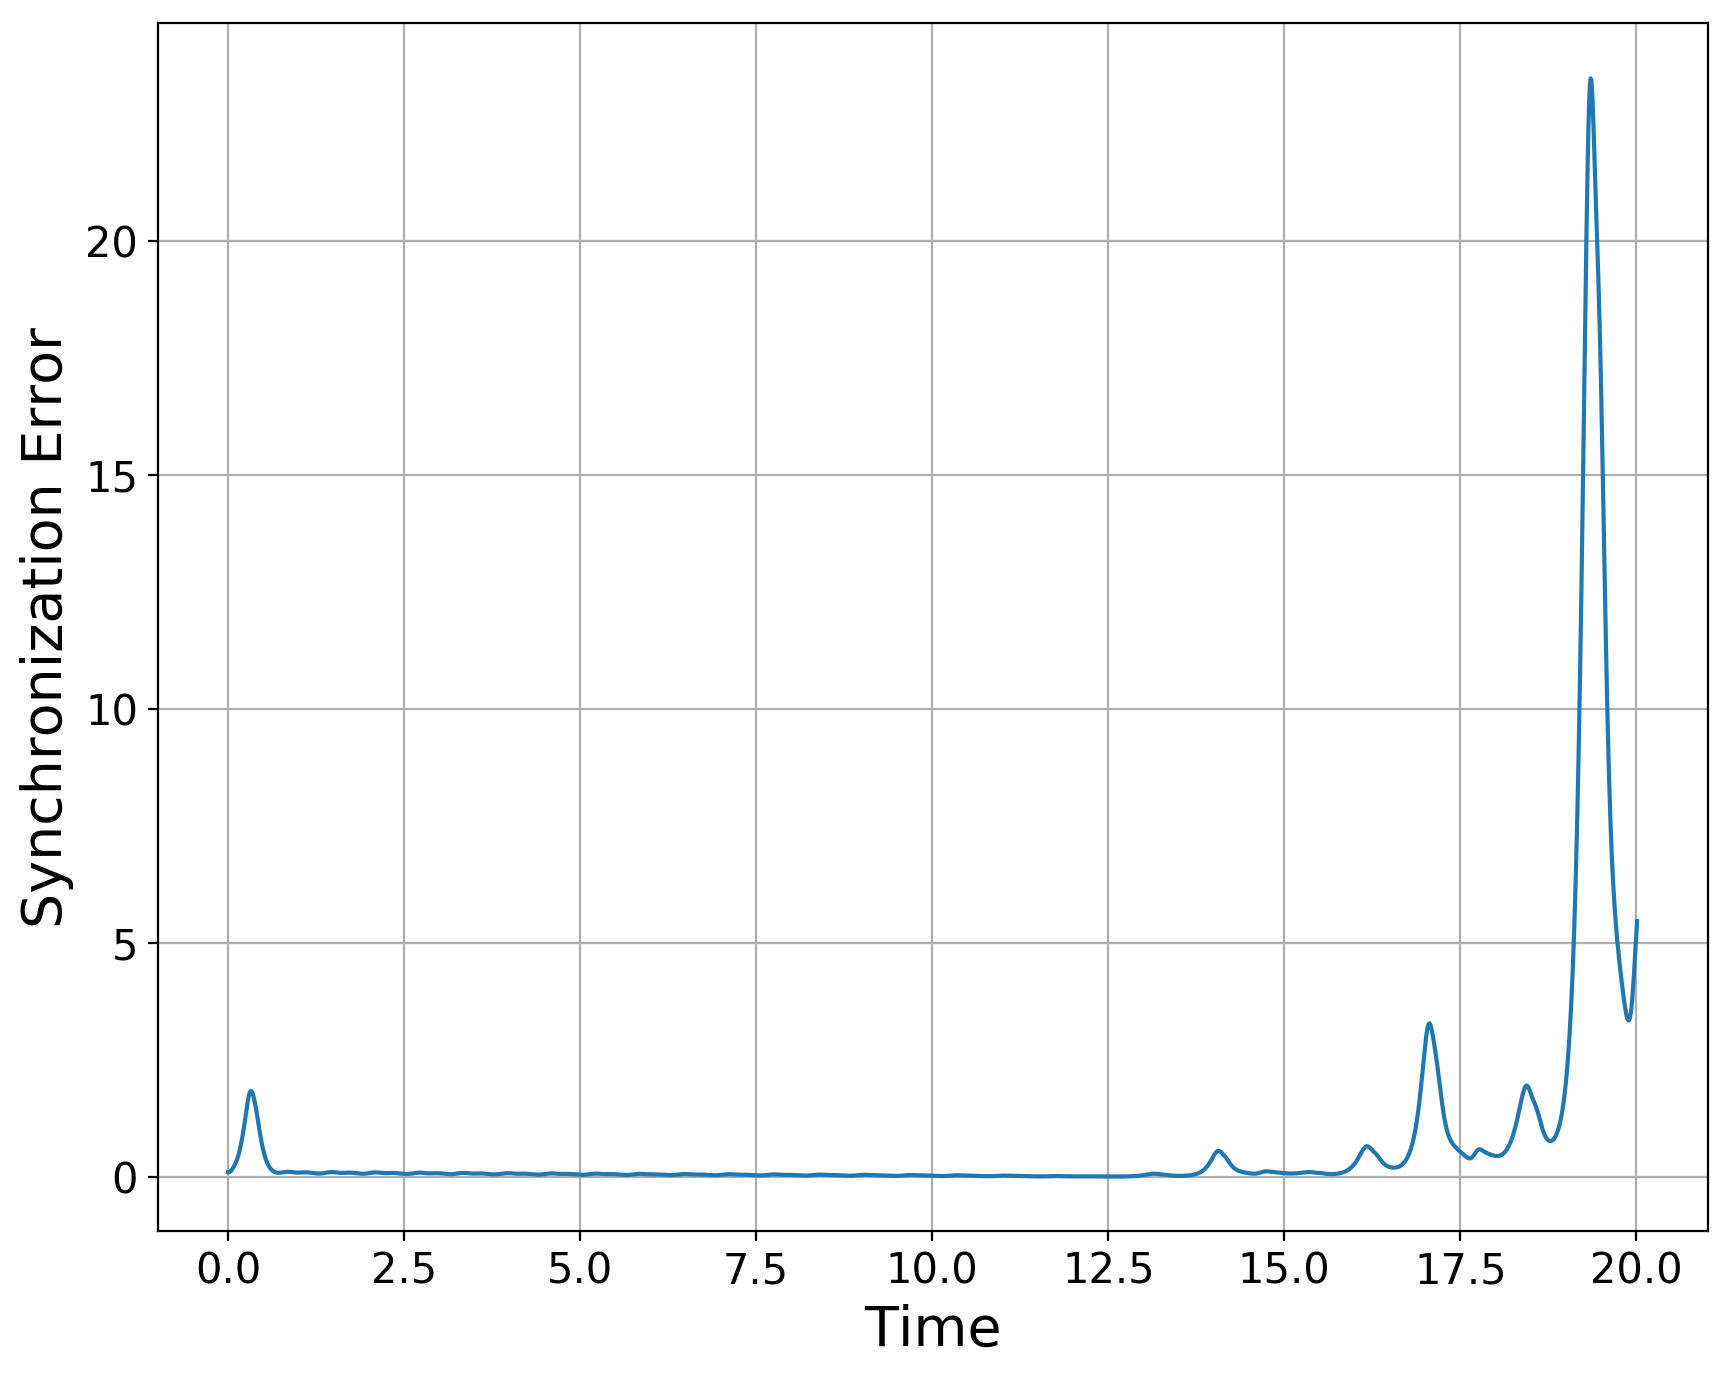

In [11]:
# calculate L_2 distance between trajectories
distance = np.linalg.norm(x_rk4[:, 0, :] - x_rk4[:, 1, :], axis=1, ord=2)

# plot synchronization error versus time
plt.plot(ts, distance)
plt.xlabel('Time')
plt.ylabel('Synchronization Error');

# TODO: Should we put a time evolution of x, y, z here?

# Synchronization in Driven Systems: A Master-Slave System

_See section 2.2.1 of [Deniz's paper](https://sites.icmc.usp.br/tiago/index.html/assets/synchronisation-of-chaos-and-its-applications.pdf) for full description_

In this setting, a master system (here chosen as a Lorenz system with parameters guaranteeing chaotic dynamics) is used to drive a slave system (a subsystem of a Lorenz system). These two systems share the set of parameters $\rho, \beta$ and $\sigma$. x-component of the master system is used to drive the slave system, which consists of only y and z components of a Lorenz system.

Such synchronization was introduced in [Pecora and Carroll, 1990]( https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.64.821).

The master system equations are:<br>
$\dot{x} = \sigma (y-x)$<br>
$\dot{y} = x(\rho-z)$-y<br>
$\dot{z} = xy - \beta z$<br>

Slave system equations are:<br>
$\dot{y}_s = x(\rho-z_s)-y_s$<br>
$\dot{z}_s = xy_s - \beta z_s$<br>
where subscript $\mathit{s}$ denotes slave system variables.  

In [12]:
def master_slave(sigma=10, rho=28, beta=2.667):
    _lorenz = lorenz(sigma, rho, beta)
    def _master_slave(y, t):
        x1 = y[0:3]
        x2 = y[3:5]
        dx1 = _lorenz(x1, t)
        dx2 = _lorenz(np.concatenate([x1[0:1], x2]), t)
        return np.concatenate([dx1, dx2[1:3]])
    return _master_slave

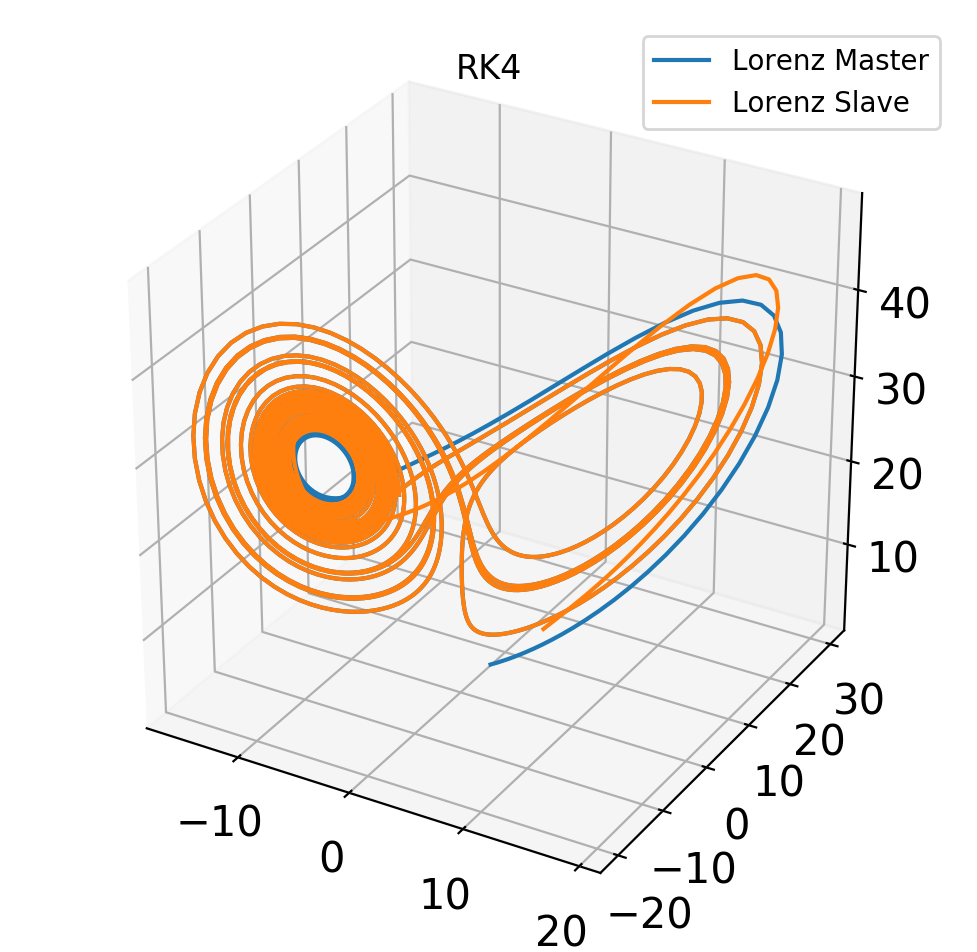

In [13]:
# define master-slave lorenz system
params = {
    'sigma': 10,
    'rho': 28,
    'beta': 2.667  
}
system = master_slave(**params)

# define the initial conditions of 5-parameter lorenz master-slave system
x0 = np.array([ 1.5, 3.0, 2.0, 15.0, 0.5 ])
t = (0, 20)
dt = 0.01

# calculate trajectory of the initial point with numerical integration
x_rk4, ts = integrate(rk4, f=system, x=x0, t=t, dt=dt)

# plot trajectories together in 3D
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs=x_rk4[:, 0], ys=x_rk4[:, 1], zs=x_rk4[:, 2])
ax.plot(xs=x_rk4[:, 0], ys=x_rk4[:, 3], zs=x_rk4[:, 4])
ax.set_title('RK4')
ax.legend(['Lorenz Master', 'Lorenz Slave']);

We can define the difference function between the $y$ and $z$ components of the Master and Slave Systems as:<br>
$\Delta y(t) = y(t) - y_s(t)$<br>
$\Delta z(t) = z(t) - z_s(t)$

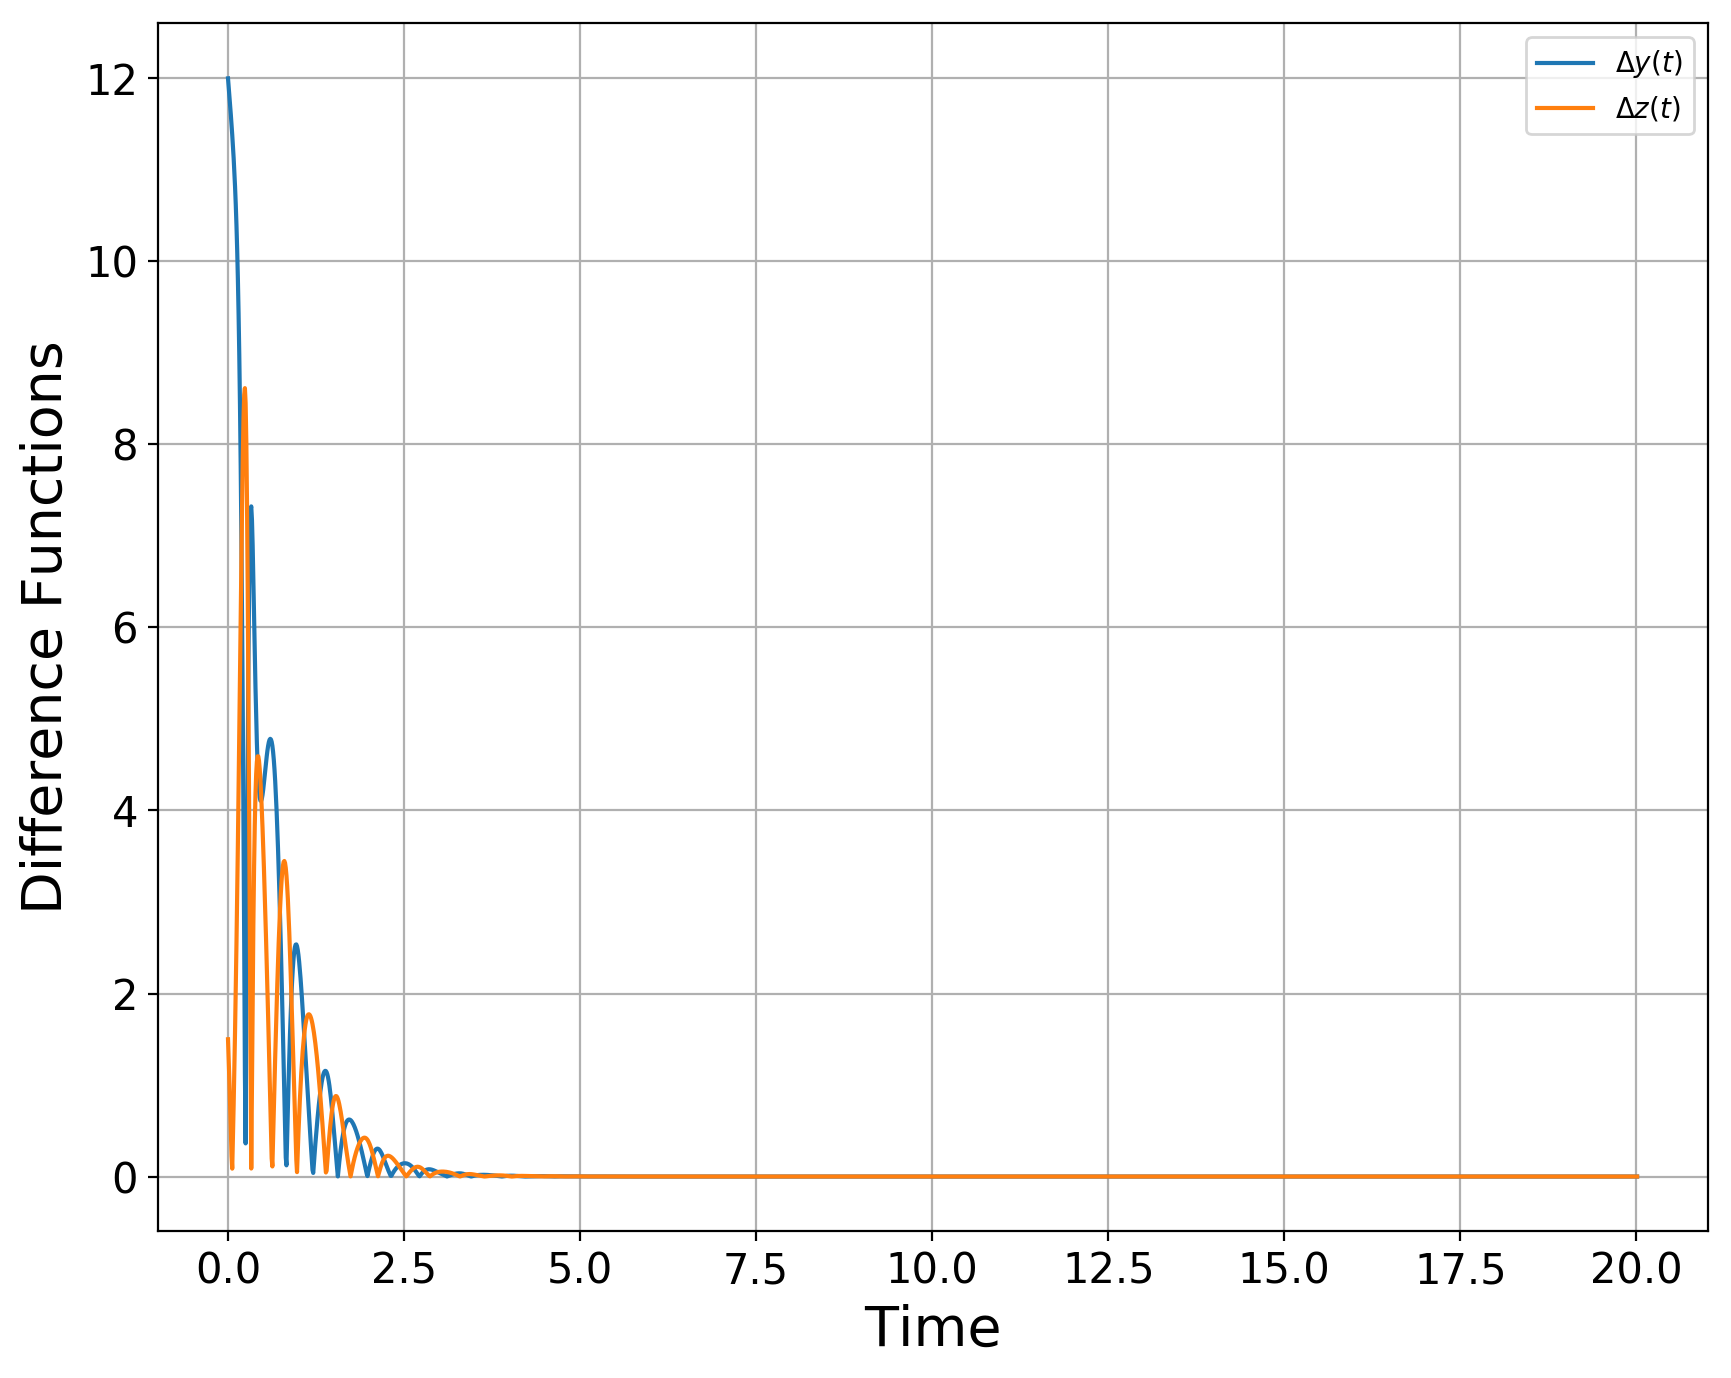

In [14]:
# calculate deltas
# use slicing like 1:2 to form N x 1D points instead of N - array for calculating norms between 1D points
distance_y = np.linalg.norm(x_rk4[:, 1:2] - x_rk4[:, 3:4], axis=1, ord=2)
distance_z = np.linalg.norm(x_rk4[:, 2:3] - x_rk4[:, 4:5], axis=1, ord=2)

# plot deltas together
plt.plot(ts, distance_y)
plt.plot(ts, distance_z)
plt.xlabel('Time')
plt.ylabel('Difference Functions')
plt.legend(['$\Delta y(t)$', '$\Delta z(t)$']);